# 1. Bag of Words Image Classification using KNN

The Bag of Words algorithm is a technique commonly used in natural language processing to represent text data as a numerical feature vector, but it can also be applied to image classification in computer vision. Bag of Words Algorithm works on image classification by extracting features from image, clustering them to form a dictionary and then creating feature vector of visual words occurrences to classify images. This technique is useful because it allows the image to be represented as a set of features that are invariant to translation and rotation, making it more robust to changes in image perspective. However, it is not robust to changes in viewpoint, illumination, scale, and deformation.

In [95]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.vq import kmeans, vq
from sklearn.preprocessing import StandardScaler

Dataset Can be accessed from: [https://www.kaggle.com/c/dogs-vs-cats/ ](https://)

In [96]:
train_path = "dog-vs-cat/train"
test_path = "dog-vs-cat/test1"

#### Collecting Train Dataset

In [97]:
labels = []
train_img_list = []
train_class_list = []

word2count = {}
for idx, folder_path in enumerate(os.listdir(train_path)):
    img_name = folder_path.split('.')
    img_class = img_name[0]
    if img_class not in labels: 
        labels.append(img_class) 
    
    if img_class not in word2count.keys():
            word2count[img_class] = 1
    else:
        word2count[img_class] += 1

    train_class_list.append(labels.index(img_class))
    image_path = train_path + "/" + folder_path
    train_img_list.append(image_path)

In [98]:
import heapq
import nltk
freq_words = heapq.nlargest(100, word2count, key=word2count.get)

X = []
for idx, folder_path in enumerate(os.listdir(train_path)):
    img_name = folder_path.split('.')
    img_class = img_name[0]
    vector = []
    for word in freq_words:
        if word in img_class:
            vector.append(1)
        else:
            vector.append(0)
    X.append(vector)
X = np.asarray(X)
print(word2count)
print(X)

{'cat': 12500, 'dog': 12500}
[[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]


#### Extracting Features

In [99]:
SIFT = cv2.SIFT_create()
train_descriptor_list = []
sub_train_img_list = train_img_list[::5]

for img in sub_train_img_list:
    _, train_descriptors = SIFT.detectAndCompute(cv2.imread(img), None)
    train_descriptor_list.append(train_descriptors)

#### Preprocessing Descriptors

In [100]:
stacked_descriptors = train_descriptor_list[0]
for desc in train_descriptor_list[1:]:
    stacked_descriptors = np.vstack((stacked_descriptors, desc))

stacked_descriptors = np.float32(stacked_descriptors) 

#### K-Means Clustering ```(from scipy.cluster.vq import kmeans) ```

In [101]:
centroids, _ = kmeans(stacked_descriptors, k_or_guess=3, iter=50)
train_features = np.zeros((len(sub_train_img_list), len(centroids)), dtype="float32")

#### BoW + Vector Quantization ```(from scipy.cluster.vq import vq)```

In [102]:
for i in range(len(sub_train_img_list)):
    words,_ = vq(train_descriptor_list[i], centroids)
    for word in words: #word -> class
        train_features[i][word] += 1

#### Rescaling train features ```(from sklearn.preprocessing import StandardScaler)```

In [103]:
std_scaler = StandardScaler().fit(train_features)
scaled_train_features = std_scaler.transform(train_features)

#### KNN Classifying ```(from sklearn.neighbors import KNeighborsClassifier) ```

In [104]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(scaled_train_features, np.array(train_class_list[::5]))

KNeighborsClassifier(n_neighbors=3)

In [105]:
from sklearn.metrics import classification_report
train_results = knn.predict(scaled_train_features)
print(classification_report(
    train_results,
    train_class_list[::5]
))

              precision    recall  f1-score   support

           0       0.77      0.76      0.76      2529
           1       0.76      0.77      0.76      2471

    accuracy                           0.76      5000
   macro avg       0.76      0.76      0.76      5000
weighted avg       0.76      0.76      0.76      5000



### Implement on Test dataset

In [106]:
test_img_list = []
for img in os.listdir(test_path):
    test_img_list.append(test_path + "/" + img)

In [107]:
test_descriptor_list = []
sub_test_img_list = test_img_list[::10]

for img in sub_test_img_list:
    _, test_descriptors = SIFT.detectAndCompute(cv2.imread(img), None)
    test_descriptor_list.append(test_descriptors)

In [108]:
test_features = np.zeros((len(sub_test_img_list), len(centroids)), dtype='float32')

In [109]:
for i in range(len(sub_test_img_list)):
    words,_ = vq(test_descriptor_list[i], centroids)
    for word in words: #word -> class
        test_features[i][word] += 1

In [110]:
scaled_test_features = std_scaler.transform(test_features)

In [111]:
results = knn.predict(scaled_test_features)

#### Display Result from Test dataset

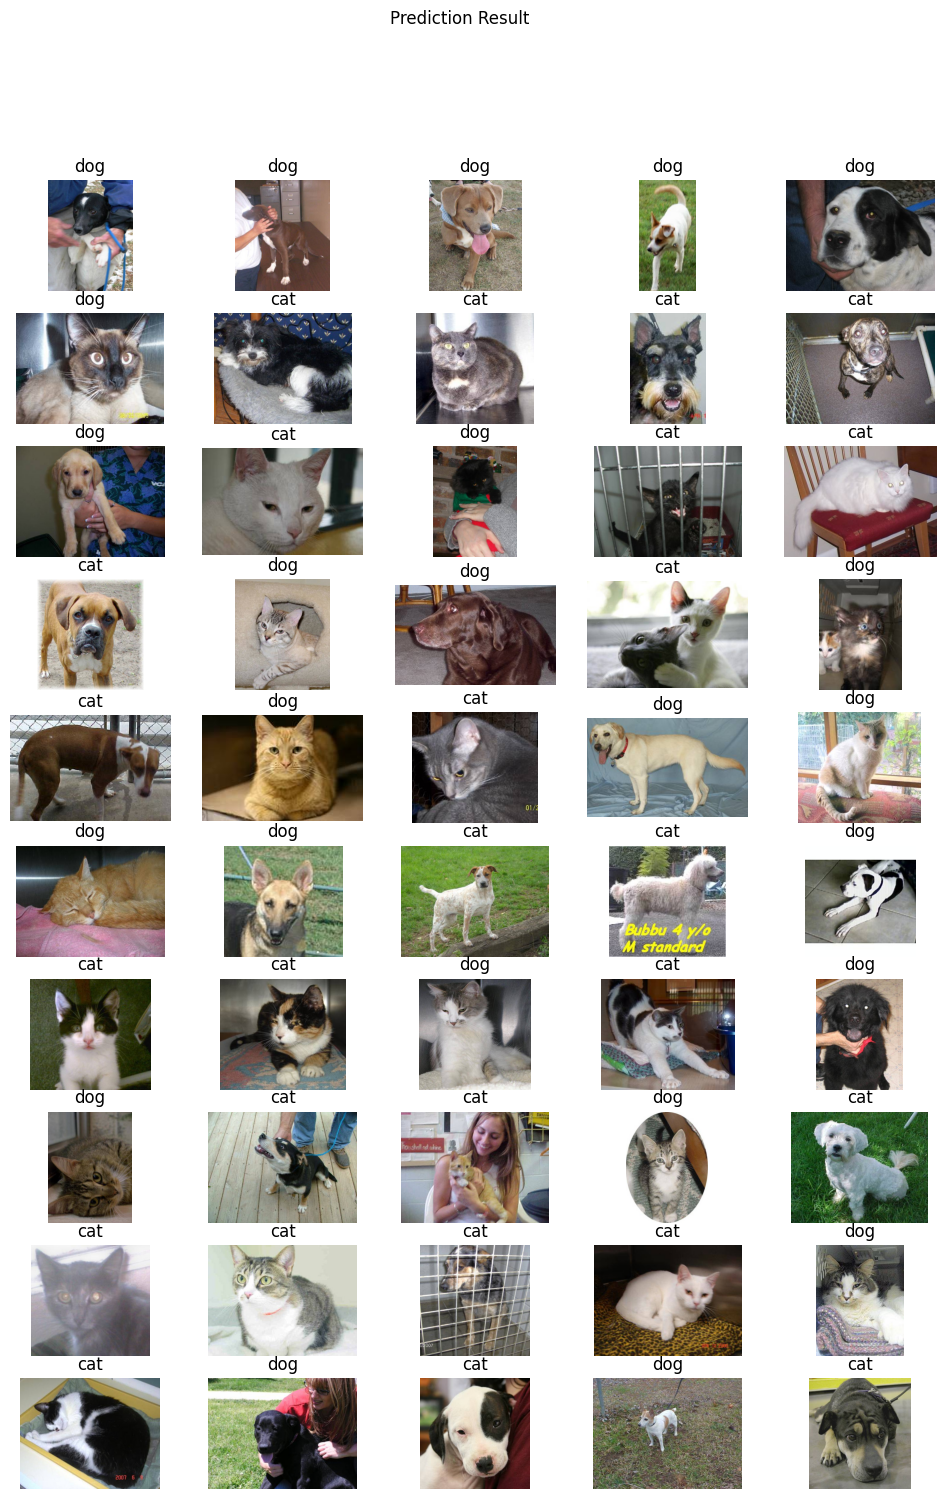

In [117]:
plt.figure(figsize=(12,17))
plt.suptitle('Prediction Result')
for idx, (id, image) in enumerate(zip(results, sub_test_img_list[::25])):
    plt.subplot(10,5,(idx+1))
    plt.title(labels[id])
    plt.imshow(cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()

The K-Nearest Neighbors (KNN) algorithm is a simple, non-parametric method used for classification and regression. In the context of image classification, the KNN algorithm works by comparing the feature vector of an input image (obtained using techniques such as the bag of words algorithm) to the feature vectors of a set of reference images, which have been previously labeled with their corresponding class labels. The KNN algorithm then finds the k closest reference images based on a distance metric, assigns the input image the class label that is most common among those k nearest neighbors. In this case, the KNN algorithm is used to classify between dog and cats.

The performance of our KNN image classification model can be evaluated by looking at its training classification report, which shows an accuracy of 76%. This metric indicates that the model is able to correctly classify 76% of the training images on average. However, upon further examination of the model's results on the testing set, it is apparent that there is room for improvement as some images of dogs and cats were falsely predicted. To improve the model performance, we may consider increasing the size of our training dataset, fine-tuning the value of k and trying different distance metric, or incorporating additional features that better capture the nuances of the images.